# <centre> Using Melspectrograms from Speech Samples to Predict Cognitive Status </centre>

In this Jupyter Notebook we convert raw audio recordings to melspectrograms for further classification with a 2D Convolutional Neural Network.  audio recordings collected from individuals diagnosed with some form of cognitive decline as well as healthy controls [1]. The objective is to give the right diagnose to these individuals based on their 30 second voice recording. The three diagnoses are: 

* Control: Healthy individual, aging in a typical way
* MCI: Mild cognitive impairment
* ADRD: Prprimary progressive aphasia (PPA), probable AD, and AD

Lets start!

## Part 1: Packages and frameworks
First we need to import some Python packages. In this notebook we will use Librosa to load the audios and Tensorflow will be used to convert the recordings to melspectrograms and to implement the 2D CNN.

In [1]:
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy import signal
import os
import numpy as np
import librosa
import librosa.display
import pandas as pd
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import Metric
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split

## Part 2: Configurations
Here we define some configurations such as paths, hyperparameters and features related to the audio files

In [2]:
SR = 16000 # Sampling frequency 
DURATION = 30 # Duration of the audio recordings, recordings that are different from 30 second will be padded or truncated to 30 seconds
EPOCHS = 15 # Number of Epochs to train the CNN
BATCH_SIZE = 20 # Number of Melspectrograms in each batch
LR = 0.001 # Learning rate 
AUDIO_DIR = "/your/path/here/train_audios" # path to the directory where the audio files are stored 

## Part 3: Load data
In this project we have the following data available:
* train_labels.csv containing label information for each patients (uid)
* audio stored as .mp3 files in train_audios/ and test_audios/. In train audios the name of the files corresponds to the uid in train_labels.csv:
   * aaop.mp3
   * abgk.mp3
   * ...
  
  in test_audios/ the filenames corresponds to the uid in submission_format.csv
* submission_format.csv show how your predictions should be formated before submission.
* metadata.csv contain information about age and gender for each patient
* train_features.csv and test_features.csv contained pre-extracted features from the recordings. These will not be used in this work

In [3]:
def load_audio(file_path, sr=SR, duration=DURATION):
    """
    Load audio files
    """
    audio, _ = librosa.load(file_path, sr=sr, duration=duration)
    return audio

def get_spectrogram(waveform):
    """
    Convert audio files to melspectrograms
    """
    spectrogram = tf.signal.stft(waveform, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram

def prepare_dataset(audio_dir, labels):
    """
    Load audio files and compute mel spectrograms

    Return all audio in directory as melspectrograms
    """
    X = []
    for file_name in tqdm(labels["uid"]):
        file_path = os.path.join(audio_dir, file_name +".mp3")
        audio = load_audio(file_path)
        audio_padded = tf.keras.utils.pad_sequences(np.expand_dims(audio,0), maxlen=480000, 
                                                    dtype='float', padding='post',truncating='post',value=0.0) # pad or truncate audio to 30 second
        audio_resamp = signal.resample(audio_padded, 120000, axis=1) # Downsample the audio by a factor of 4
        mel_spec = get_spectrogram(audio_resamp)
        X.append(mel_spec[0]) 
    X = np.array(X)
    return X

def plot_spectrogram(spectrogram):
    """
    A function used to plot melspectrograms
    """
    if len(spectrogram.shape) > 2:
        assert len(spectrogram.shape) == 3
        spectrogram = np.squeeze(spectrogram, axis=-1)
    log_spec = np.log(spectrogram.T + np.finfo(float).eps)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    plt.pcolormesh(X, Y, log_spec)

In [4]:
# Import meta data and train labels (I hereby call it development data)
meta = pd.read_csv("/your/path/here/metadata.csv")
y_dev = pd.read_csv("/your/path/here/train_labels.csv")

100%|██████████| 1646/1646 [02:14<00:00, 12.28it/s]


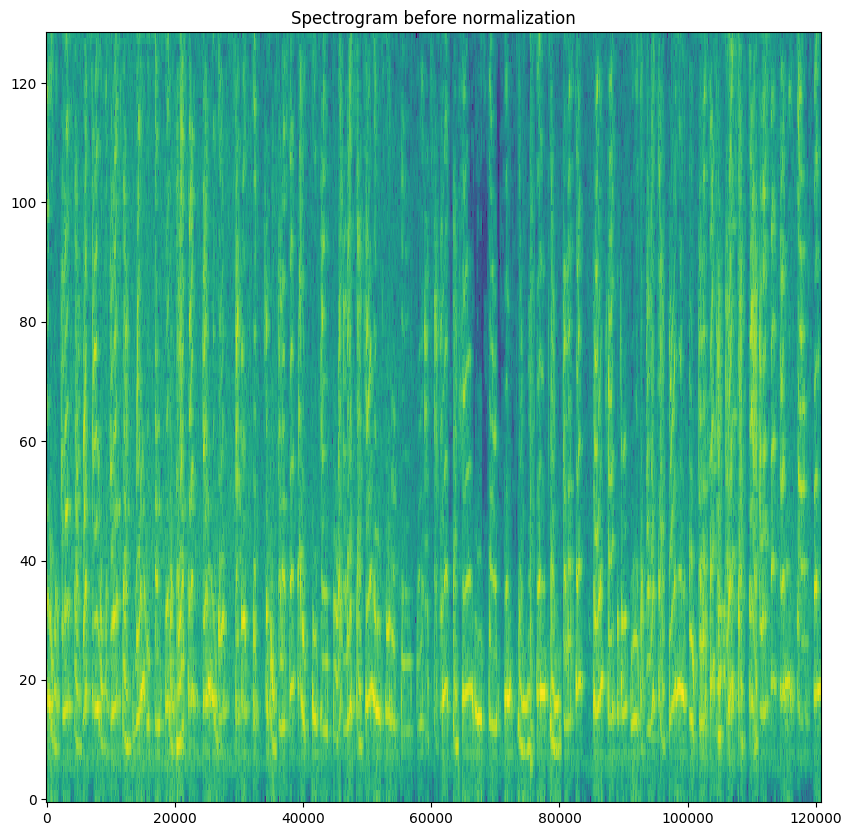

/tmp/ipykernel_23/4138093932.py:42: RuntimeWarning: invalid value encountered in log
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)


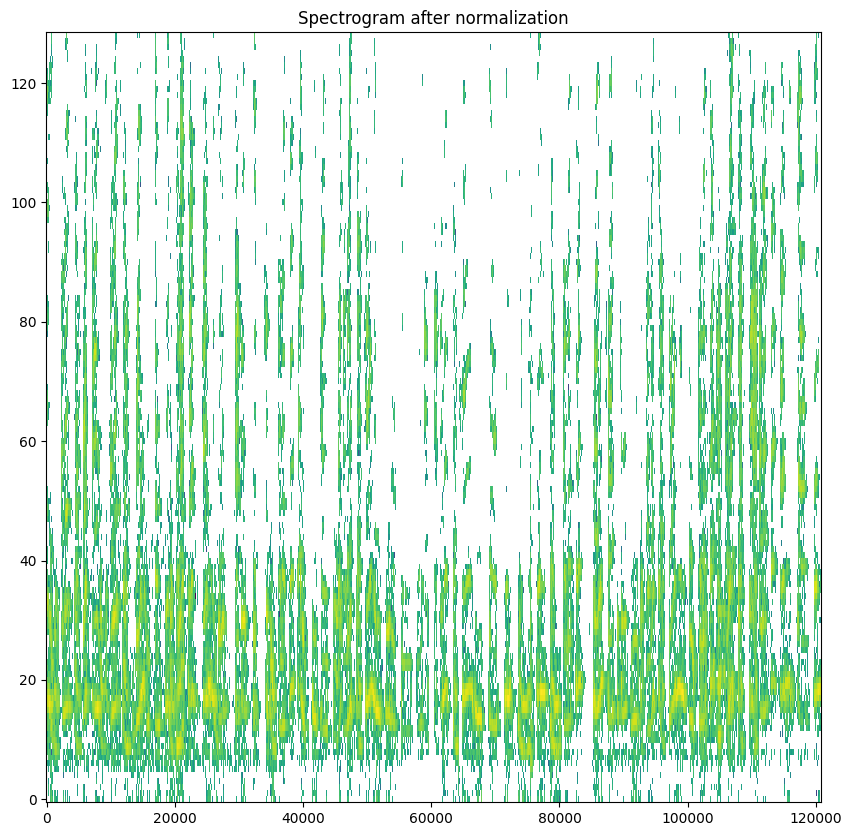

In [5]:
# Load data 
X = prepare_dataset(AUDIO_DIR, y_dev)

# plot an example of the data
plt.figure(figsize=(10,10))
plt.title("Spectrogram before normalization")
plot_spectrogram(X[0,:,:,:])
plt.show()

# Normalize all spectrograms using the mean and standard deviation
mean = np.mean(X)
std = np.std(X)
X = (X - mean) / std

# plot same spectrogram after normalization
plt.figure(figsize=(10,10))
plt.title("Spectrogram after normalization")
plot_spectrogram(X[0,:,:,:])
plt.show()

In [6]:
# assign labels to y and split development data into train (80%) and validation data (20%)
y = y_dev[["diagnosis_control","diagnosis_mci","diagnosis_adrd"]]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training data size: ", X_train.shape[0])
print("Validation data size: ", X_val.shape[0])

Training data size:  1316
Validation data size:  330


In [7]:
# assign shape of training data to input_shape and number of classes to num_labels
input_shape = X_train.shape[1:]
num_labels = y_train.shape[1]

## Part 4: Train model
We use a ConvNeXt model as feature extractor to classify our melspectrograms. Furthermore we employ a custom made metric and use focal loss to put more focus on examples which are hard to classify correct

In [8]:
class LogLossMetric(Metric):
    """ 
    Custom loss function to compute log_loss which is the metric to minimize in this challenge
    Created using ChatGPT
    """    
    def __init__(self, name='log_loss', **kwargs):
        super(LogLossMetric, self).__init__(name=name, **kwargs)
        self.total_loss = self.add_weight(name="total_loss", initializer="zeros")
        self.count = self.add_weight(name="count", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Clip predictions to avoid log(0) errors
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())

        # Compute log loss for the current batch
        loss = -K.mean(y_true * K.log(y_pred) + (1 - y_true) * K.log(1 - y_pred))

        # Update the total loss and count of samples
        self.total_loss.assign_add(loss)
        self.count.assign_add(1)

    def result(self):
        # Return the average log loss
        return self.total_loss / self.count

    def reset_state(self):
        # Reset the state variables
        self.total_loss.assign(0)
        self.count.assign(0)

In [9]:
%%capture
# Use ConvNeXt as feature extractor
def create_convnext_model(input_shape, num_classes):
    base_model = tf.keras.applications.ConvNeXtTiny(  # Use Tiny or other variants
        input_shape=input_shape,
        include_top=False,
        #weights="imagenet",
        weights=None,
        pooling="avg"
    )
    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(3,activation="softmax") # add softmax at final layer
    ])
    return model

model = create_convnext_model(input_shape=input_shape, num_classes=num_labels)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
    loss=tf.keras.losses.CategoricalFocalCrossentropy(), # use focal loss to focus more on data which is hard to classify
    metrics=[LogLossMetric()]
)
# Train and validate model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)


results = model.evaluate(X_val, y_val)
print("Evaluation Results:", results)

y_val_hat = model.predict(X_val)

print(log_loss(y_val,y_val_hat))

I0000 00:00:1732696919.211521      75 service.cc:145] XLA service 0x7f6220005690 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732696919.211611      75 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1732696939.575071      75 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_58', 116 bytes spill stores, 116 bytes spill loads

I0000 00:00:1732696939.620028      75 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
I0000 00:00:1732696980.701343      73 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_58', 116 bytes spill stores, 116 bytes spill loads



In [10]:
%%capture
# Perform final training on all development data
model = create_convnext_model(input_shape=input_shape, num_classes=num_labels)

model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=LR),
    loss=tf.keras.losses.CategoricalFocalCrossentropy(),
    metrics=[LogLossMetric()]
)

history = model.fit(
    X, y,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)

I0000 00:00:1732697406.375676      74 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_60', 120 bytes spill stores, 120 bytes spill loads

I0000 00:00:1732697454.531300      75 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion_9', 1648 bytes spill stores, 1548 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_229', 444 bytes spill stores, 316 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion_20', 1592 bytes spill stores, 1492 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_58', 120 bytes spill stores, 120 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_53', 120 bytes spill stores, 120 bytes spill loads



## Part 5: Inference and submission
Now when we have our final model, trained on all devlopment data, we employ it on the test set and then structure our predictions like in submission_format.csv.
The final submission will be stored in a csv filed called submission.csv. This file is ready for upload to the [submission page](https://www.drivendata.org/competitions/299/competition-nih-alzheimers-acoustic-2/submissions/)

In [11]:
sub = pd.read_csv("/your/path/here/submission_format.csv") # read submission file
X_sub = prepare_dataset("/your/path/here/test_audios/", sub) # read all test data and make melspectrograms
X_sub = (X_sub - mean) / std # Normalize all spectrograms using the mean and standard deviation from the training data
y_hat_sub = model.predict(X_sub) # Do predictions on the melspectrograms

100%|██████████| 412/412 [00:28<00:00, 14.48it/s]


13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 495ms/step


In [12]:
sub[["diagnosis_control","diagnosis_mci","diagnosis_adrd"]] = y_hat_sub # assign predictions to the three classes 
sub.to_csv("submission.csv", index=False) # Save predictions to a csv file

# References

[1] https://www.drivendata.org/competitions/299/competition-nih-alzheimers-acoustic-2/page/929/#data
